# 🚗 Explainable Self-Driving Model Training

This notebook guides you through training the **PilotNet CNN** model for autonomous driving using the CARLA Autopilot dataset.

## Overview
1. **Setup**: Import dependencies and configure environment
2. **Data Loading**: Load and preprocess the HuggingFace dataset
3. **Model Definition**: Instantiate PilotNet architecture
4. **Training Loop**: Train with MSE loss
5. **Evaluation**: Validate model performance
6. **XAI Visualization**: Demonstrate Grad-CAM explanations

## 1. Setup & Imports

In [1]:
import sys
import os

# Add project root to path
sys.path.insert(0, os.path.abspath('.'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
from PIL import Image

from models.pilot_net import PilotNet
from utils.preprocessing import get_transforms, denormalize_image

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

p:\Projects\Automanus-car\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu


## 2. Configuration

In [2]:
# Hyperparameters - CACHED FAST MODE
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
SAVE_DIR = './models'
TRAIN_STEPS_PER_EPOCH = 10  # Very small for fast demo (40 samples total)
VAL_STEPS = 5

os.makedirs(SAVE_DIR, exist_ok=True)


## 3. Data Loading (Streaming - Fast Start)

In [3]:
print("Loading dataset in streaming mode...")
ds = load_dataset("immanuelpeter/carla-autopilot-multimodal-dataset", streaming=True)
print("Dataset loaded!")
print(f"Available splits: {list(ds.keys())}")

Loading dataset in streaming mode...
Dataset loaded!
Available splits: ['train', 'validation', 'test']


In [4]:
# FAST TRAINING: Cache data in RAM to avoid network lag per epoch
print('Prefetching data into RAM for speed...')
train_buffer = []
val_buffer = []

train_stream = iter(ds['train'])
val_stream = iter(ds['test'])

# Fetch training data
for _ in tqdm(range(TRAIN_STEPS_PER_EPOCH * BATCH_SIZE), desc='Caching Train Data'):
    try:
        item = next(train_stream)
        train_buffer.append(item)
    except StopIteration:
        break

# Fetch validation data
for _ in tqdm(range(VAL_STEPS * BATCH_SIZE), desc='Caching Val Data'):
    try:
        item = next(val_stream)
        val_buffer.append(item)

    except StopIteration:
        break

print(f'Cached {len(train_buffer)} train samples and {len(val_buffer)} val samples.')


Prefetching data into RAM for speed...


Caching Val Data: 100%|██████████| 20/20 [00:48<00:00,  2.44s/it]

Cached 40 train samples and 20 val samples.


In [5]:
from torch.utils.data import Dataset

class CachedCarlaDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        item = self.data_list[idx]
        image = item.get('image_front')
        if image is None: image = item.get('image')
        
        steering = float(item.get('steer', 0.0))
        throttle = float(item.get('throttle', 0.0))
        brake = float(item.get('brake', 0.0))
        
        # Transform is handled by utils/preprocessing now (including rgb convert)
        if self.transform:
            image = self.transform(image)
            
        controls = torch.tensor([steering, throttle, brake], dtype=torch.float32)
        return image, controls


In [6]:
# Create Transforms
transform_train = get_transforms(train=True)
transform_val = get_transforms(train=False)

# Create Datasets from RAM buffer
train_dataset = CachedCarlaDataset(train_buffer, transform=transform_train)
val_dataset = CachedCarlaDataset(val_buffer, transform=transform_val)

# Create DataLoaders (Worker API compatible now that data is local)
# We set num_workers=0 to avoid Windows spawning issues in notebooks, but 2 might work
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Fast DataLoaders Ready! Training should be instant after cache.')


Fast DataLoaders Ready! Training should be instant after cache.


### Quick Sample Preview (1 image only)

Fetching 1 sample for preview...
Sample keys: ['run_id', 'frame', 'timestamp', 'image_front', 'image_front_left', 'image_front_right', 'image_rear', 'seg_front', 'lidar', 'boxes', 'box_labels', 'location_x', 'location_y', 'location_z', 'rotation_pitch', 'rotation_yaw', 'rotation_roll', 'velocity_x', 'velocity_y', 'velocity_z', 'speed_kmh', 'throttle', 'steer', 'brake', 'nearby_vehicles_50m', 'total_npc_vehicles', 'total_npc_walkers', 'map_name', 'weather_cloudiness', 'weather_precipitation', 'weather_fog_density', 'weather_sun_altitude', 'vehicles_spawned', 'walkers_spawned', 'duration_seconds']


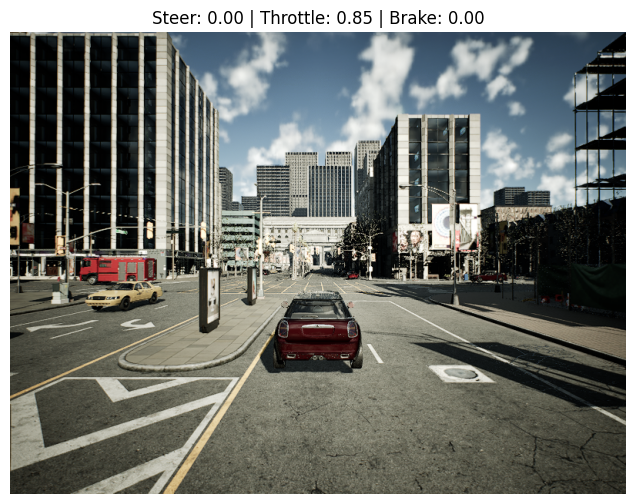

Preview complete!


In [7]:
# Quick preview - just 1 sample
print("Fetching 1 sample for preview...")
sample = next(iter(ds['train']))
print(f"Sample keys: {list(sample.keys())}")

# Show the image
img = sample['image_front']
steer = sample.get('steer', 0)
throttle = sample.get('throttle', 0) 
brake = sample.get('brake', 0)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title(f"Steer: {steer:.2f} | Throttle: {throttle:.2f} | Brake: {brake:.2f}")
plt.axis('off')
plt.show()
print("Preview complete!")

## 4. Model Definition

In [8]:
model = PilotNet().to(device)
print(model)

# Test forward pass
dummy_input = torch.randn(1, 3, 66, 200).to(device)
output = model(dummy_input)
print(f"\nInput: {dummy_input.shape} -> Output: {output.shape}")

PilotNet(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

Input: torch.Size([1, 3, 66, 200]) -> Output: torch.Size([1, 3])


## 5. Training Loop

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

In [10]:
from evaluation.metrics import calculate_metrics, calculate_f1_score
for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss, train_steps = 0.0, 0
    train_iter = iter(train_loader)
    
    pbar = tqdm(range(TRAIN_STEPS_PER_EPOCH), desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for _ in pbar:
        try:
            images, controls = next(train_iter)
        except StopIteration:
            break
            
        images, controls = images.to(device), controls.to(device)
        
        optimizer.zero_grad()
        loss = criterion(model(images), controls)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_steps += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        
    avg_train = train_loss / max(train_steps, 1)
    history['train_loss'].append(avg_train)
    
    # Validation
    model.eval()
    val_loss, val_steps = 0.0, 0
    val_iter = iter(val_loader)

    # Lists for metrics
    val_outputs = []
    val_targets = []

    # Lists for metrics
    val_outputs = []
    val_targets = []

    # Lists for metrics
    val_outputs = []
    val_targets = []
    
    with torch.no_grad():
        for _ in tqdm(range(VAL_STEPS), desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False):
            try:
                images, controls = next(val_iter)
            except StopIteration:
                break
            images, controls = images.to(device), controls.to(device)
            output = model(images)
            val_loss += criterion(output, controls).item()
            val_outputs.append(output.cpu())
            val_targets.append(controls.cpu())
            val_steps += 1
            
    if len(val_outputs) > 0:
        all_preds = torch.cat(val_outputs, dim=0).numpy()
        all_targs = torch.cat(val_targets, dim=0).numpy()
        print(f"\n--- Epoch {epoch+1} Metrics ---")
        calculate_metrics(all_preds, all_targs)

    if len(val_outputs) > 0:
        all_preds = torch.cat(val_outputs, dim=0).numpy()
        all_targs = torch.cat(val_targets, dim=0).numpy()
        print(f"\n--- Epoch {epoch+1} Metrics ---")
        calculate_metrics(all_preds, all_targs)
        calculate_f1_score(all_preds, all_targs)

    if len(val_outputs) > 0:
        all_preds = torch.cat(val_outputs, dim=0).numpy()
        all_targs = torch.cat(val_targets, dim=0).numpy()
        print(f"\n--- Epoch {epoch+1} Metrics ---")
        calculate_metrics(all_preds, all_targs)
        calculate_f1_score(all_preds, all_targs)

    avg_val = val_loss / max(val_steps, 1)
    history['val_loss'].append(avg_val)
    
    print(f"Epoch {epoch+1}: Train={avg_train:.4f}, Val={avg_val:.4f}")
    
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'pilot_net_best.pth'))
        print("✅ Saved best model!")

print("\n🎉 Training Complete!")

Epoch 1/5 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.54it/s, loss=0.3308]



--- Epoch 1 Metrics ---
Metrics (Steering, Throttle, Brake):
MSE: [4.6450010e-04 8.5845716e-02 8.8441515e-01]
MAE: [0.02153268 0.14483128 0.89272356]
Epoch 1: Train=0.2797, Val=0.3236
✅ Saved best model!


Epoch 2/5 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s, loss=0.2920]



--- Epoch 2 Metrics ---
Metrics (Steering, Throttle, Brake):
MSE: [0.00599491 0.08771624 0.78091943]
MAE: [0.0772064  0.14857249 0.84419906]
Epoch 2: Train=0.2629, Val=0.2915
✅ Saved best model!


Epoch 3/5 [Train]: 100%|██████████| 10/10 [00:00<00:00, 11.39it/s, loss=0.1783]



--- Epoch 3 Metrics ---
Metrics (Steering, Throttle, Brake):
MSE: [0.09164812 0.07500267 0.3774103 ]
MAE: [0.30177146 0.19618165 0.6053933 ]
Epoch 3: Train=0.2138, Val=0.1814
✅ Saved best model!


Epoch 4/5 [Train]: 100%|██████████| 10/10 [00:00<00:00, 10.78it/s, loss=0.1179]



--- Epoch 4 Metrics ---
Metrics (Steering, Throttle, Brake):
MSE: [0.05308992 0.09804479 0.31254667]
MAE: [0.22972521 0.2843125  0.55476606]
Epoch 4: Train=0.1588, Val=0.1546
✅ Saved best model!


Epoch 5/5 [Train]: 100%|██████████| 10/10 [00:00<00:00, 10.41it/s, loss=0.1399]
                                                      


--- Epoch 5 Metrics ---
Metrics (Steering, Throttle, Brake):
MSE: [0.0287721  0.10889678 0.30539998]
MAE: [0.16927661 0.30999148 0.5485076 ]
Epoch 5: Train=0.1437, Val=0.1477
✅ Saved best model!

🎉 Training Complete!


### Training History

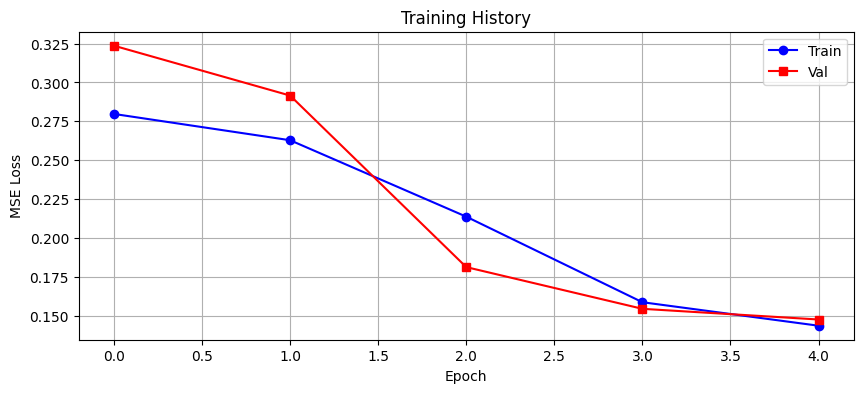

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r-s', label='Val')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Training History'); plt.legend(); plt.grid(True)
plt.show()

## 6. XAI: Grad-CAM

In [12]:
import importlib
import xai.grad_cam
# Force reload of Grad-CAM module to pick up bug fixes
importlib.reload(xai.grad_cam)
from xai.grad_cam import GradCamExplainer
print("Module reloaded!")

Module reloaded!


In [13]:
from xai.grad_cam import GradCamExplainer
import cv2

# Load best model
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'pilot_net_best.pth'), map_location=device))
model.eval()

grad_cam = GradCamExplainer(model, model.conv5)
print("Grad-CAM ready!")

Grad-CAM ready!


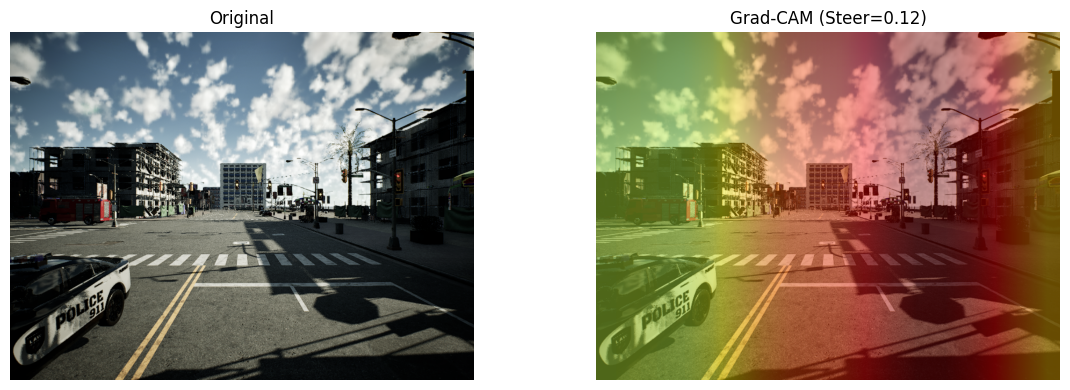

Prediction: Steer=0.12, Throttle=0.20, Brake=0.36


In [14]:
# Get 1 sample and explain
sample = next(iter(ds['test']))
img_pil = sample['image_front']
transform = get_transforms(train=False)
img_tensor = transform(img_pil).unsqueeze(0).to(device)

# Predict and explain
with torch.no_grad():
    pred = model(img_tensor).cpu().numpy()[0]

heatmap = grad_cam.explain(img_tensor, target_index=0)  # Steering
heatmap_resized = cv2.resize(heatmap, (img_pil.size[0], img_pil.size[1]))

# Overlay
img_np = np.array(img_pil)
overlay = grad_cam.visualize(img_np / 255.0, heatmap_resized)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(img_pil); axes[0].set_title('Original'); axes[0].axis('off')
axes[1].imshow(overlay); axes[1].set_title(f'Grad-CAM (Steer={pred[0]:.2f})'); axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f"Prediction: Steer={pred[0]:.2f}, Throttle={pred[1]:.2f}, Brake={pred[2]:.2f}")

## 6.1 XAI: LIME (Local Interpretable Model-agnostic Explanations)

In [15]:
import importlib
import sys

# 1. Unload the module from cache if it exists
if 'xai.lime_explainer' in sys.modules:
    del sys.modules['xai.lime_explainer']

# 2. Re-import
import xai.lime_explainer
importlib.reload(xai.lime_explainer)
from xai.lime_explainer import LimeExplainer

# 3. Re-instantiate
lime_exp = LimeExplainer(model)
print("LIME Explainer reloaded and re-initialized (V3)!")

LIME Explainer reloaded and re-initialized (V3)!


In [16]:
import importlib
import xai.lime_explainer
# Force reload of LIME module
importlib.reload(xai.lime_explainer)
from xai.lime_explainer import LimeExplainer
print("LIME Module reloaded!")

LIME Module reloaded!


LIME Explainer ready!
Generating LIME explanation (this may take a minute)...


100%|██████████| 500/500 [01:23<00:00,  5.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


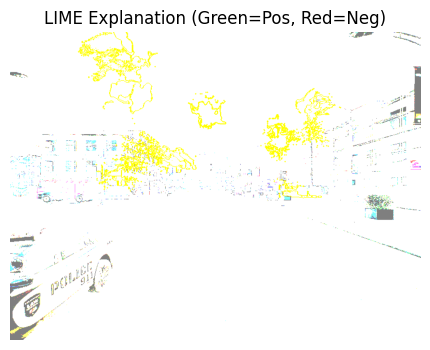

In [17]:
from xai.lime_explainer import LimeExplainer

# Prepare LIME explainer
lime_exp = LimeExplainer(model)
print("LIME Explainer ready!")

# Ensure image is numpy (H, W, 3) for LIME
img_np = np.array(img_pil)

print("Generating LIME explanation (this may take a minute)...")
lime_overlay = lime_exp.explain(img_np, target_index=0, num_samples=500)
plt.figure(figsize=(6, 4))
plt.imshow(lime_overlay)
plt.title("LIME Explanation (Green=Pos, Red=Neg)")
plt.axis('off')
plt.show()                       

## 6.2 XAI: SHAP (SHapley Additive exPlanations)

Preparing SHAP background data...
SHAP Explainer ready!
Generating SHAP values...


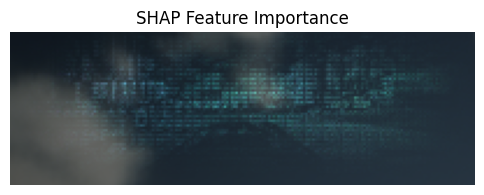

In [18]:
from xai.shap_explainer import ShapExplainer

# Prepare Background data for DeepExplainer/GradientExplainer
# We need a batch of tensors. Let's grab 50 random samples from train loader.
print("Preparing SHAP background data...")
background_batch = []
count = 0
for imgs, _ in train_loader:
    background_batch.append(imgs)
    count += len(imgs)
    if count >= 50: break

background_tensor = torch.cat(background_batch)[:50].to(device)

shap_exp = ShapExplainer(model, background_tensor)
print("SHAP Explainer ready!")

print("Generating SHAP values...")
shap_heatmap = shap_exp.explain(img_tensor, target_index=0)

plt.figure(figsize=(6, 4))
plt.imshow(img_pil)
plt.imshow(shap_heatmap, cmap='jet', alpha=0.5)
plt.title("SHAP Feature Importance")
plt.axis('off')
plt.show()

## 7. Save Model

In [19]:
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'best_val_loss': best_val_loss
}, os.path.join(SAVE_DIR, 'pilot_net_final.pth'))
print("✅ Model saved!")

✅ Model saved!


---
## Next Steps
- **CARLA**: `python main.py drive --xai grad_cam`
- **Dashboard**: `streamlit run ui/dashboard.py`